# Bitcoin price predictor using RNN

## Load data

In [1]:
import pandas as pd
import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt
%matplotlib inline
import random
random.seed(123)
import seaborn as sns
import datetime
from datetime import date
import yfinance as yf

In [2]:
########## DOWNLOAD DATA DIRECTLY FROM YAHOO FINANCE ##########
# BITCOIN, US DOLLAR, VOLATILITY INDEX, S&P 500, DOW JONES, GOLD PRICE, OIL PRICE
stocks = ['BTC-USD','^DJI', 'NOG','DX-Y.NYB','^GDAXI','^IXIC'] #### ADD FEATURES HERE ####
end = datetime.date.today()
start = datetime.datetime(2019,1,2)
stock_prices = yf.download(stocks,start=start,end = end, interval='1d')

[*********************100%***********************]  6 of 6 completed


In [3]:
raw_df = stock_prices
raw_df.head(2)

Adj Close                                               \
                BTC-USD   DX-Y.NYB   NOG          ^DJI        ^GDAXI   
Date                                                                   
2019-01-02  3943.409424  96.820000  24.5  23346.240234  10580.190430   
2019-01-03  3836.741211  96.309998  24.4  22686.220703  10416.660156   

                               Close                                 ...  \
                  ^IXIC      BTC-USD   DX-Y.NYB   NOG          ^DJI  ...   
Date                                                                 ...   
2019-01-02  6665.939941  3943.409424  96.820000  24.5  23346.240234  ...   
2019-01-03  6463.500000  3836.741211  96.309998  24.4  22686.220703  ...   

            Open                                               Volume  \
             NOG          ^DJI        ^GDAXI        ^IXIC     BTC-USD   
Date                                                                    
2019-01-02  22.1  23058.609375  10477.769531  6506.910156  5244856835   
2019-01-03  24.5  23176.390625  10467.110352  6584.770020  4530215218   

                                                                      
           DX-Y.NYB       NOG         ^DJI      ^GDAXI         ^IXIC  
Date                                                                  
2019-01-02      0.0  354300.0  321570000.0  79626700.0  2.261800e+09  
2019-01-03      0.0  280300.0  424240000.0  84733800.0  2.607290e+09  

[2 rows x 36 columns]

In [4]:
raw_df['Date'] =  raw_df.index

In [5]:
raw_df['Date'] = pd.to_datetime(raw_df['Date'])

## Check features correlation with BITCOIN 

In [6]:
stock_prices['Close'].corr()

,BTC-USD,DX-Y.NYB,NOG,^DJI,^GDAXI,^IXIC
BTC-USD,1.000000,-0.424758,-0.654218,0.500355,0.469043,0.732410
DX-Y.NYB,-0.424758,1.000000,0.307506,-0.488744,-0.416812,-0.672304
NOG,-0.654218,0.307506,1.000000,0.003377,-0.007338,-0.749678
^DJI,0.500355,-0.488744,0.003377,1.000000,0.946408,0.571395
^GDAXI,0.469043,-0.416812,-0.007338,0.946408,1.000000,0.549738
^IXIC,0.732410,-0.672304,-0.749678,0.571395,0.549738,1.000000


<AxesSubplot:>

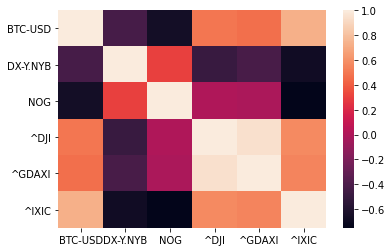

In [7]:
sns.heatmap(stock_prices['Close'].corr())

## Exploratory analysis

## formatting data - from yahoo finance

In [8]:
def get_data(indices,keys):
    a =[(key,index) for key in keys for index in indices]
    return raw_df[a] 

In [9]:
####### INCLUDE NEW FEATURES HERE ####### 
df = get_data(['BTC-USD','^DJI', 'NOG','DX-Y.NYB','^GDAXI','^IXIC'],['Close','High','Low','Volume'])  

In [10]:
df.head(3)

Close                                               \
                BTC-USD          ^DJI   NOG   DX-Y.NYB        ^GDAXI   
Date                                                                   
2019-01-02  3943.409424  23346.240234  24.5  96.820000  10580.190430   
2019-01-03  3836.741211  22686.220703  24.4  96.309998  10416.660156   
2019-01-04  3857.717529  23433.160156  27.1  96.190002  10767.690430   

                                High                                 ...  \
                  ^IXIC      BTC-USD          ^DJI   NOG   DX-Y.NYB  ...   
Date                                                                 ...   
2019-01-02  6665.939941  3947.981201  23413.470703  24.5  96.959999  ...   
2019-01-03  6463.500000  3935.685059  23176.390625  24.9  96.750000  ...   
2019-01-04  6738.859863  3865.934570  23518.640625  27.4  96.610001  ...   

                  Low                                            Volume  \
                  NOG   DX-Y.NYB        ^GDAXI        ^IXIC     BTC-USD   
Date                                                                      
2019-01-02  21.600000  95.820000  10386.969727  6506.879883  5244856835   
2019-01-03  23.299999  96.209999  10400.110352  6457.129883  4530215218   
2019-01-04  24.799999  96.050003  10483.900391  6554.240234  4847965467   

                                                                      
                   ^DJI       NOG DX-Y.NYB      ^GDAXI         ^IXIC  
Date                                                                  
2019-01-02  321570000.0  354300.0      0.0  79626700.0  2.261800e+09  
2019-01-03  424240000.0  280300.0      0.0  84733800.0  2.607290e+09  
2019-01-04  396020000.0  485300.0      0.0  95339500.0  2.579550e+09  

[3 rows x 24 columns]

## Data preprossesing

### getting rid of NaNs

In [11]:
df = df.fillna(method='ffill')

### calculating percentage change of btc_price

In [12]:
df['percentage_change_price'] = df['Close']['BTC-USD'].pct_change()

In [13]:
####### CHECK UNBALANCED DATA SET ########
(df['percentage_change_price']>0).value_counts()

True     371
False    322
Name: percentage_change_price, dtype: int64

## Transform Date

In [14]:
df.columns

MultiIndex(levels=[['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'Date', 'percentage_change_price'], ['BTC-USD', 'DX-Y.NYB', 'NOG', '^DJI', '^GDAXI', '^IXIC', '']],
           codes=[[1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 7], [0, 3, 2, 1, 4, 5, 0, 3, 2, 1, 4, 5, 0, 3, 2, 1, 4, 5, 0, 3, 2, 1, 4, 5, 6]])

In [15]:
new_colum_names = []
for el1, el2 in df.columns:
    new_colum_names.append(el1 + "_" + el2)
new_colum_names

['Close_BTC-USD',
 'Close_^DJI',
 'Close_NOG',
 'Close_DX-Y.NYB',
 'Close_^GDAXI',
 'Close_^IXIC',
 'High_BTC-USD',
 'High_^DJI',
 'High_NOG',
 'High_DX-Y.NYB',
 'High_^GDAXI',
 'High_^IXIC',
 'Low_BTC-USD',
 'Low_^DJI',
 'Low_NOG',
 'Low_DX-Y.NYB',
 'Low_^GDAXI',
 'Low_^IXIC',
 'Volume_BTC-USD',
 'Volume_^DJI',
 'Volume_NOG',
 'Volume_DX-Y.NYB',
 'Volume_^GDAXI',
 'Volume_^IXIC',
 'percentage_change_price_']

In [16]:
df.columns = new_colum_names

In [17]:
df['Date'] = df.index

In [18]:
df['Date'] = pd.to_datetime(df['Date'])
df['month'] = df['Date'].dt.month

df['year'] = df['Date'].dt.year

In [19]:
# Define percentage change in price column
df['delta_binary'] = df.percentage_change_price_>0
df['delta_binary'] = df['delta_binary'].astype(int)
df.head(2)

,Close_BTC-USD,Close_^DJI,Close_NOG,Close_DX-Y.NYB,Close_^GDAXI,Close_^IXIC,High_BTC-USD,High_^DJI,High_NOG,High_DX-Y.NYB,...,Volume_^DJI,Volume_NOG,Volume_DX-Y.NYB,Volume_^GDAXI,Volume_^IXIC,percentage_change_price_,Date,month,year,delta_binary
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,3943.409424,23346.240234,24.5,96.820000,10580.190430,6665.939941,3947.981201,23413.470703,24.5,96.959999,...,321570000.0,354300.0,0.0,79626700.0,2.261800e+09,NaN,2019-01-02,1,2019,0
2019-01-03,3836.741211,22686.220703,24.4,96.309998,10416.660156,6463.500000,3935.685059,23176.390625,24.9,96.750000,...,424240000.0,280300.0,0.0,84733800.0,2.607290e+09,-0.02705,2019-01-03,1,2019,0


In [20]:
df[['percentage_change_price_','delta_binary']].head(2)

,percentage_change_price_,delta_binary
Date,,
2019-01-02,NaN,0
2019-01-03,-0.02705,0


In [21]:
scaled_names = df.columns[:-1]
scaled_names

Index(['Close_BTC-USD', 'Close_^DJI', 'Close_NOG', 'Close_DX-Y.NYB',
       'Close_^GDAXI', 'Close_^IXIC', 'High_BTC-USD', 'High_^DJI', 'High_NOG',
       'High_DX-Y.NYB', 'High_^GDAXI', 'High_^IXIC', 'Low_BTC-USD', 'Low_^DJI',
       'Low_NOG', 'Low_DX-Y.NYB', 'Low_^GDAXI', 'Low_^IXIC', 'Volume_BTC-USD',
       'Volume_^DJI', 'Volume_NOG', 'Volume_DX-Y.NYB', 'Volume_^GDAXI',
       'Volume_^IXIC', 'percentage_change_price_', 'Date', 'month', 'year'],
      dtype='object')

## Data Sampling

- Out of this very long time-series, we will subsample it into shorter samples, each corresponding to one sequence of data  𝑋𝑖  with its corresponding prediction  𝑦𝑖 .
- get_sample -> function to get this random sample

Note:
  
  - **length** corresponds to the lenght of the observed sequence
  - **temporal_horizon** corresponds to the number of days between your last seen stock market value and the day you are trying to predict. -> in our case we want to predict for now the day after so tempor_horizon =1

In [22]:

def get_sample(df, length, temporal_horizon):
    
    features = [col_name for col_name in df.columns if col_name not in {'Date', 'Close_BTC-USD','delta_binary',
                                                                        'percentage_change_price_'} ]
    
    temporal_horizon = temporal_horizon - 1
    last_possible = df.shape[0] - temporal_horizon - length

    random_start = np.random.randint(0, last_possible)
    X_sample = df[features].iloc[random_start: random_start+length].values ## we need to say which features we are using??!
    y_sample = df['delta_binary'].iloc[random_start+length+temporal_horizon]
    y_before = df['delta_binary'].iloc[random_start+length+temporal_horizon-1]
   
    return X_sample, y_sample, y_before

get_sample(df,1,1)

For instance, get_sample(df, 10, 3) returns a first list of **10 stock market values**, and a second value which is the stock market value 3 days after the last seen value.

## Dataset construction

The previous function creates a sample (𝑋𝑖,𝑦𝑖) . If we repeat this operation, we will get multiple samples, that once concatenated will correspond to our entire dataset (𝑋,𝑦) .

Create a function get_X_y(data, temporal_horizon, length_of_sequences) that create this dataset.

- data corresponds to your input data
- temporal_horizon is the number of days between the last seen value and the predicted one
- length_of_sequences is a list that corresponds to the length of each sample 𝑋𝑖 : [len(X_1), len(X_2), len(X_3), ..., ] as that each sequence 𝑋𝑖 has no reason to be of the same length as the other one.

Hint: This function should use get_sample

In [23]:
# create a matrix
def get_X_y(df, temporal_horizon, length_of_sequences):
    X, y, y_before = [], [], []

    for len_ in length_of_sequences:
        xi, yi, y_bi = get_sample(df, len_, temporal_horizon)
        X.append(xi)
        y.append(yi)
        y_before.append(y_bi)
        
    return X, np.array(y), np.array(y_before)

 - Write a function given a dataframe, a temporal horizon and a list of sequence length outputs the padded train and test set.
 - To have a batch_size larger than one, we need to **pad** our data_ purely engineering reason
 

In [24]:
from sklearn.model_selection import train_test_split

def generate_data(df_train, df_test, temporal_horizon, min_len, max_len):
      
    length_of_sequences_train = np.random.randint(min_len, max_len, len(df_train)) 
    length_of_sequences_test = np.random.randint(min_len, max_len, len(df_test)) 
    
    # Train 
    X_train, y_train, y_b_train = get_X_y(df_train, temporal_horizon, length_of_sequences_train)
    X_train = pad_sequences(X_train, padding='post', dtype='float32')
   
    # Test
    X_test, y_test, y_b_test = get_X_y(df_test, temporal_horizon, length_of_sequences_test)
    X_test = pad_sequences(X_test, padding='post', dtype='float32')
    
    return X_train, X_test, y_train, y_test, y_b_test, y_b_train

- Generate data with a temporal horizon of 1 days, and 100 time-series of 10 to 10 seen days .

## Split data

In [25]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Splitting 80/20
start = 1 # do a for loop
index = round((len(df)-start)*.8)

# Past
df_train = df.iloc[start:index+start]

#Future
df_test = df.iloc[start+index:]


temporal_horizon = 1 # -> predict the day after
min_len = 20
max_len = 30
#(group 10 days,group of 20 days , # observations each time)


In [26]:
#df.head(2)

In [27]:
df_test = df_test.drop(columns = 'Date')
df = df.drop(columns = ['Date'])

In [28]:
df_train = df_train.drop(columns = 'Date')

df_test.dtypes

## Feature scaling

##### Fetaure scaling: only on train data ######

In [29]:
# Scaling: MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

#features_list = [col_name for col_name in df.columns if col_name not in {'Date', 'Close'} ]

# normalizing features
normalizer_features = MinMaxScaler()
normalizer_features.fit(df_train)
scaled_df = pd.DataFrame(normalizer_features.transform(df))

# mormalizing output/target
#normalizer_output = MinMaxScaler()
#normalizer_output.fit(df_train[['percentage_change_price']])
#scaled_df['percentage_change_price'] = normalizer_output.transform(df[['percentage_change_price']])
scaled_df['delta_binary'] = df.reset_index()[['delta_binary']]

# not normalizing, uncomment this
# scaled_df = df

## Generate data sequences

In [30]:
scaled_df_train, scaled_df_test = scaled_df.iloc[start:(index+start)], scaled_df.iloc[start+index:]

In [31]:
X_train, X_test, y_train, y_test, y_b_test, y_b_train = generate_data(scaled_df_train,
                                                    scaled_df_test, temporal_horizon, min_len, max_len)

In [32]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_b_train.shape)
print(y_b_test.shape)

(554, 29, 28)
(138, 29, 28)
(554,)
(138,)
(554,)
(138,)


## Baseline model: LSTM with feature scaling 

- LSTM: Introduced to prevent the vanishing gradient: for **long** time-series, the gradient (of the backpropagation, during the optimizer updates) vanished to 0.

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

def init_model():

    model = Sequential()
    model.add(layers.Masking())
    model.add(layers.LSTM(7, activation='tanh'))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', 
                  optimizer='rmsprop', 
                  metrics=['accuracy'])# find loss an penalizing negative or positive results - alternatives to mae
                                  # mae weighted
    return model


In [34]:
# Fit the model
from tensorflow.keras.callbacks import EarlyStopping

model = init_model()

es = EarlyStopping(patience=40, mode='min', verbose=1, monitor='val_loss',restore_best_weights=True)
# patience = 30 - > if my algorithm doesnt improve my performance for a certain number of iterations 
# (patience) stop the fitting process, return the weights as they are

history = model.fit(X_train,y_train,
          batch_size=16,
          epochs=10000, # iteration through your data
          validation_split=0.2,
          callbacks=[es],
          verbose=1)

Epoch 1/10000
28/28 [==============================] - 9s 331ms/step - loss: 0.6940 - accuracy: 0.5011 - val_loss: 0.7083 - val_accuracy: 0.4234
Epoch 2/10000
28/28 [==============================] - 1s 53ms/step - loss: 0.6920 - accuracy: 0.5327 - val_loss: 0.6967 - val_accuracy: 0.4144
Epoch 3/10000
28/28 [==============================] - 2s 57ms/step - loss: 0.6909 - accuracy: 0.5395 - val_loss: 0.6964 - val_accuracy: 0.4144
Epoch 4/10000
28/28 [==============================] - 2s 55ms/step - loss: 0.6867 - accuracy: 0.5711 - val_loss: 0.7120 - val_accuracy: 0.3964
Epoch 5/10000
28/28 [==============================] - 2s 59ms/step - loss: 0.6873 - accuracy: 0.5350 - val_loss: 0.6966 - val_accuracy: 0.4414
Epoch 6/10000
28/28 [==============================] - 2s 57ms/step - loss: 0.6847 - accuracy: 0.5756 - val_loss: 0.6974 - val_accuracy: 0.4685
Epoch 7/10000
28/28 [==============================] - 1s 53ms/step - loss: 0.6825 - accuracy: 0.5643 - val_loss: 0.6962 - val_accuracy

28/28 [==============================] - 2s 54ms/step - loss: 0.5827 - accuracy: 0.6772 - val_loss: 0.7796 - val_accuracy: 0.5405
Epoch 114/10000
28/28 [==============================] - 1s 51ms/step - loss: 0.5864 - accuracy: 0.7111 - val_loss: 0.6602 - val_accuracy: 0.6486
Epoch 115/10000
28/28 [==============================] - 2s 54ms/step - loss: 0.5853 - accuracy: 0.6727 - val_loss: 0.6658 - val_accuracy: 0.6216
Epoch 116/10000
28/28 [==============================] - 1s 52ms/step - loss: 0.5725 - accuracy: 0.6727 - val_loss: 0.6934 - val_accuracy: 0.5766
Epoch 117/10000
28/28 [==============================] - 2s 56ms/step - loss: 0.5756 - accuracy: 0.6772 - val_loss: 0.6882 - val_accuracy: 0.6126
Epoch 118/10000
28/28 [==============================] - 1s 51ms/step - loss: 0.5674 - accuracy: 0.6862 - val_loss: 0.7624 - val_accuracy: 0.5495
Epoch 119/10000
28/28 [==============================] - 1s 52ms/step - loss: 0.5756 - accuracy: 0.6975 - val_loss: 0.6779 - val_accuracy: 0

#history.history

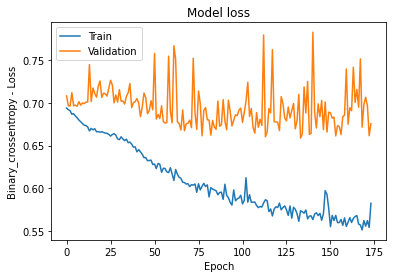

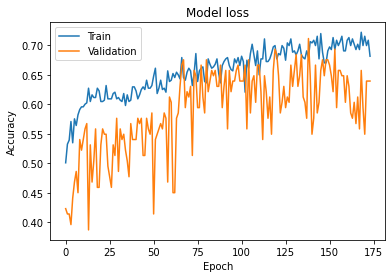

In [35]:

def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Binary_crossentropy - Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model loss')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()
    
plot_loss(history)

In [36]:
y_pred = model.predict(X_test)
res = model.evaluate(X_test,y_test)
print(f'Loss on the test set : {res[0]:.8f}')
print(f'Accuracy on the test set : {res[1]:.8f}')

5/5 [==============================] - 0s 9ms/step - loss: 0.6641 - accuracy: 0.5942
Loss on the test set : 0.66408241
Accuracy on the test set : 0.59420288
